In [12]:
# Importar librerías esenciales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [13]:
# Cargar datos de entrenamiento
train_data = pd.read_csv('data/train.csv')

# Cargar datos de prueba
test_data = pd.read_csv('data/test.csv')

# Ver las primeras filas del dataframe de prueba
test_data.head()

# Cargar archivo objetivo (target)
target_data = pd.read_csv('data/target.csv')




In [14]:
# Identificar columnas numéricas y categóricas
numeric_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = train_data.select_dtypes(include=['object']).columns

# Crear un pipeline para datos numéricos (imputación con la media y escalado)
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputación con la media
    ('scaler', StandardScaler())  # Escalado de las características numéricas
])

# Crear un pipeline para datos categóricos (imputación con la moda y codificación)
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputación con el valor más frecuente
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Codificación one-hot
])

# Combinamos ambos pipelines usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ]
)

# Aplicamos el preprocesamiento
train_data_processed = preprocessor.fit_transform(train_data)

# Convertimos el resultado a DataFrame para que sea más fácil de manejar (si es necesario)
train_data_processed = pd.DataFrame(train_data_processed)

# Ver las primeras filas del DataFrame procesado
train_data_processed.head()

,0
0,"(0, 0)\t1.4344236033145197\n (0, 1)\t1.2940..."
1,"(0, 0)\t0.5275132367104777\n (0, 1)\t1.2940..."
2,"(0, 0)\t-0.652132039331488\n (0, 1)\t0.4398..."
3,"(0, 0)\t-0.08492438433255999\n (0, 1)\t-0.3..."
4,"(0, 0)\t1.7312739247014861\n (0, 1)\t1.2940..."


In [25]:
# Definir características (X) y variable objetivo (y)
X = train_data.drop('RENDIMIENTO_GLOBAL', axis=1)  # Usamos 'RENDIMIENTO_GLOBAL' como variable objetivo
y = train_data['RENDIMIENTO_GLOBAL']  # Asignamos 'RENDIMIENTO_GLOBAL' como objetivo

# Verificamos si 'RENDIMIENTO_GLOBAL' fue correctamente eliminada de X
print("Características X:", X.columns)
print("Variable objetivo y:", y.name)

# Dividir en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir primeras filas de X_train y y_train para comprobar
print(X_train.head())
print(y_train.head())

Características X: Index(['ID', 'PERIODO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO',
       'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA',
       'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE',
       'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD',
       'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR',
       'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE', 'coef_1', 'coef_2',
       'coef_3', 'coef_4'],
      dtype='object')
Variable objetivo y: RENDIMIENTO_GLOBAL
            ID  PERIODO                  ESTU_PRGM_ACADEMICO  \
80918   133959    20203  ADMINISTRACIÓN EN SALUD OCUPACIONAL   
641723  784510    20212           ADMINISTRACION DE EMPRESAS   
352261  535024    20183     INGENIERIA AMBIENTAL Y SANITARIA   
108353  591650    20212                   CONTADURIA PUBLICA   
257387  635933    20195                   CONTADURIA PUBLICA   

       ESTU_PRGM_DEPARTAMENTO            ESTU_VALORMATRICULAUNIVERSIDAD  \
8091

In [29]:
from sklearn.preprocessing import LabelEncoder
# Codificar la variable objetivo 'RENDIMIENTO_GLOBAL'
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Verificar cómo quedó la variable objetivo codificada
print("Variable objetivo codificada:", y_encoded[:10])

Variable objetivo codificada: [2 1 1 0 3 2 0 3 3 0]


In [30]:
# Eliminar posibles espacios al principio o al final de los nombres de las columnas
train_data.columns = train_data.columns.str.strip()

# Verificar que la columna objetivo 'RENDIMIENTO_GLOBAL' está limpia
print(train_data.columns)


Index(['ID', 'PERIODO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO',
       'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA',
       'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE',
       'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD',
       'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR',
       'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL',
       'coef_1', 'coef_2', 'coef_3', 'coef_4'],
      dtype='object')


In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Eliminar espacios invisibles en las columnas
train_data.columns = train_data.columns.str.strip()

# Verificar que la columna objetivo 'RENDIMIENTO_GLOBAL' esté presente
print("Columnas en el DataFrame:", train_data.columns)

# Separar 'RENDIMIENTO_GLOBAL' como variable objetivo (y) y las características (X)
X = train_data.drop('RENDIMIENTO_GLOBAL', axis=1)
y = train_data['RENDIMIENTO_GLOBAL']

# Codificar la variable objetivo 'RENDIMIENTO_GLOBAL' si es categórica
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Codificamos la variable objetivo

# Identificar columnas numéricas y categóricas
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Crear pipeline para datos numéricos (imputación con la media)
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputación con la media
])

# Crear pipeline para datos categóricos (imputación con la moda y codificación OneHot)
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputación con la moda
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Codificación one-hot
])

# Combinamos ambos pipelines usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ]
)

# Dividir en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Aplicar el preprocesamiento solo a las características (X)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Entrenar RandomForest utilizando múltiples núcleos
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)  # Usar todos los núcleos
rf_model.fit(X_train_processed, y_train)

# Realizar predicciones
y_pred_rf = rf_model.predict(X_test_processed)





Columnas en el DataFrame: Index(['ID', 'PERIODO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO',
       'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA',
       'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE',
       'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD',
       'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR',
       'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL',
       'coef_1', 'coef_2', 'coef_3', 'coef_4'],
      dtype='object')


Accuracy de RandomForest: 0.40707581227436823
AUC de RandomForest (multiclase): 0.6749540292126153


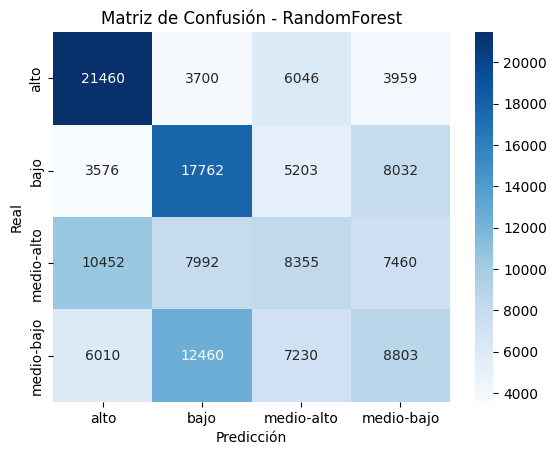

In [36]:
from sklearn.metrics import roc_auc_score

# Evaluar el modelo
print("Accuracy de RandomForest:", accuracy_score(y_test, y_pred_rf))

# Calcular el AUC para problemas multiclase (One-vs-Rest)
auc_score = roc_auc_score(y_test, rf_model.predict_proba(X_test_processed), multi_class='ovr')
print("AUC de RandomForest (multiclase):", auc_score)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - RandomForest')
plt.show()



In [41]:
from sklearn.model_selection import RandomizedSearchCV  # Asegúrate de importar RandomizedSearchCV

# Definir los parámetros para la búsqueda aleatoria (sin 'auto' en 'max_features')
param_dist = {
    'n_estimators': [50, ],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2],  # Número mínimo de muestras en un nodo hoja
    'max_features': ['sqrt', 'log2', None]  # Cambiar 'auto' por valores válidos
}

# Crear el modelo RandomForest
rf_model = RandomForestClassifier(random_state=42)

# Usar RandomizedSearchCV para encontrar los mejores hiperparámetros
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_processed, y_train)

# Ver los mejores parámetros encontrados
print("Mejores parámetros encontrados:", random_search.best_params_)




Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 